In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('fake.csv', usecols = ['uuid','author','title','text','language','site_url','country'])
df = df[df.language == 'english']
df = df[df['text'].map(type) == str]
df['title'].fillna(value="", inplace=True)
df.dropna(axis=0, inplace=True, subset=['text'])
# shuffle the data
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head()

<class 'list'>


In [4]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

<class 'list'>


In [5]:
t1 = time.time()
df['tokenized'] = df['text'].apply(apply_all) + df['title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 12357 articles: 2.6672693332036337 min
<class 'list'>


In [6]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

96280

In [7]:
k = 15000
top_k_words = fdist.most_common(k)
top_k_words[-10:]


[('larvacid', 13),
 ('imax', 13),
 ('clickhol', 13),
 ('wachovia', 13),
 ('nongaap', 13),
 ('hanson', 13),
 ('viper', 13),
 ('cf', 13),
 ('toyota', 13),
 ('indiarussia', 13)]

In [8]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [9]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

In [10]:
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))



length of list: 12357 
average document length 345.66828518248764 
minimum document length 0 
maximum document length 11576


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


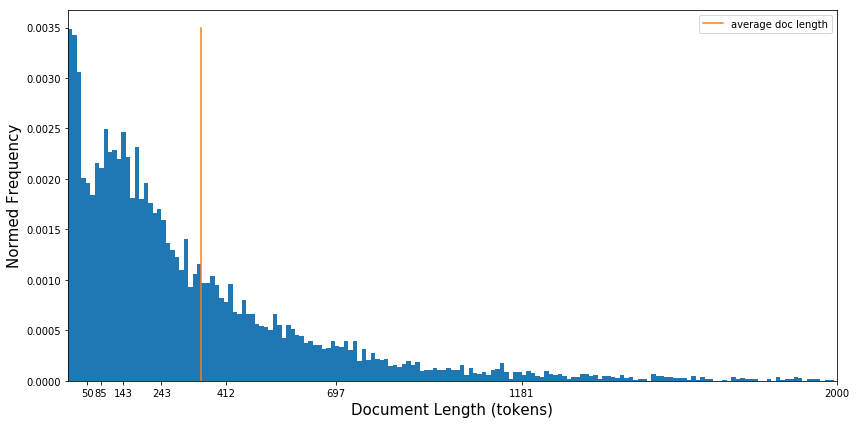

In [11]:
num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,2000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [12]:
# only keep articles with more than 30 tokens, otherwise too short
df = df[df['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

After cleaning and excluding short aticles, the dataframe now has: 10812 articles


In [13]:
df.head()

,uuid,author,title,text,language,site_url,country,tokenized
0,6a119140f1bf8fbbbe7e812521eecaf5095da46e,Zero Hedge,"Wikileaks Releases “DoJ, FBI, Huma Special” Po...","\nMoments ago, after teasing its twitter follo...",english,thedailysheeple.com,US,"[moment, ago, twitter, follow, stay, tune, pod..."
1,cf94a9dde4a5894f5a0a36d75be412bb38888af0,Dawn Parabellum,WikiLeaks Initiates Phase 3: The Dump That Wil...,WikiLeaks Initiates Phase 3: The Dump That Wil...,english,madworldnews.com,US,"[wikileak, initi, phase, dump, take, hillari, ..."
2,5bf91ffc2e9b12067b78ce9a021b18201d20dad2,The Mind Unleashed,Pakistani Parliament is the first in the world...,Pakistani Parliament is the first in the world...,english,themindunleashed.com,US,"[pakistani, parliament, first, world, go, full..."
3,4477c2e81fe1b07f3efde8327b477325fa7acd53,Scott Osborn,BREAKING: Trump VP Plane Slides Off Runway at ...,0 comments GOP VP candidate Mike Pence’s Trump...,english,ihavethetruth.com,US,"[comment, gop, vp, candid, mike, penc, trump, ..."
4,bad9a82686d77e09db7813e71ef4c88136c58a94,Jason Ditz,"Shi’ite Militias Enter Mosul Battle, But Eyes ...",Deployment Meant to Block ISIS Escape by Jason...,english,antiwar.com,US,"[deploy, meant, block, isi, escap, jason, ditz..."


In [14]:
# create a mask of binary values
msk = np.random.rand(len(df)) < 0.999


In [15]:
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [16]:
print(len(df),len(train_df),len(test_df))

10812 10800 12


In [17]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 50
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [18]:
dictionary,corpus,lda = train_lda(train_df)

/usr/local/lib/python3.6/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Time to train LDA model on  10812 articles:  0.7219852328300476 min


In [39]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=50, num_words=20)


[(0,
  '0.022*"law" + 0.016*"govern" + 0.010*"court" + 0.010*"feder" + 0.009*"use" + 0.009*"public" + 0.008*"act" + 0.008*"state" + 0.007*"case" + 0.007*"constitut" + 0.006*"offic" + 0.006*"depart" + 0.006*"inform" + 0.006*"agenc" + 0.006*"order" + 0.006*"legal" + 0.006*"justic" + 0.005*"issu" + 0.005*"right" + 0.005*"document"'),
 (1,
  '0.011*"dr" + 0.010*"vaccin" + 0.008*"medic" + 0.008*"use" + 0.008*"drug" + 0.007*"doctor" + 0.007*"mani" + 0.007*"one" + 0.005*"children" + 0.005*"peopl" + 0.005*"studi" + 0.005*"effect" + 0.005*"even" + 0.004*"cdc" + 0.004*"industri" + 0.004*"research" + 0.004*"patient" + 0.004*"posit" + 0.004*"scienc" + 0.004*"death"'),
 (2,
  '0.118*"muslim" + 0.079*"islam" + 0.068*"turkey" + 0.037*"turkish" + 0.025*"erdogan" + 0.019*"email" + 0.015*"click" + 0.013*"address" + 0.013*"read" + 0.013*"terror" + 0.013*"copyright" + 0.011*"use" + 0.011*"jihad" + 0.011*"terrorist" + 0.010*"list" + 0.010*"name" + 0.010*"join" + 0.009*"galacticconnectioncom" + 0.009*"permi

In [23]:
lda.show_topic(topicid=32, topn=20)

[('us', 0.014802029),
 ('plane', 0.012596404),
 ('island', 0.010343882),
 ('new', 0.010329306),
 ('philippin', 0.009809174),
 ('flight', 0.008102482),
 ('fli', 0.0080610765),
 ('dutert', 0.0069332095),
 ('south', 0.0064959833),
 ('airport', 0.006170847),
 ('visit', 0.006146044),
 ('korean', 0.005940869),
 ('flare', 0.00572485),
 ('australia', 0.0057240706),
 ('pilot', 0.005497682),
 ('reach', 0.0053160815),
 ('zone', 0.0049532754),
 ('land', 0.0048579215),
 ('object', 0.004800635),
 ('jet', 0.004737804)]

In [24]:

random_article_index = np.random.randint(len(train_df))
random_article_index = 10
bow = dictionary.doc2bow(train_df.iloc[random_article_index,7])

print(random_article_index)
list_topic_train=[len(train_df)]
print (list_topic_train)

list_topic_test=[len(test_df)]
print (list_topic_test)

10
[10800]
[12]


In [25]:
#print(train_df.iloc[random_article_index,3])
for i in range(0,len(train_df)):
    
    bow = dictionary.doc2bow(train_df.iloc[i,7])
    doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])
    lis=(lda.get_document_topics(bow=bow))
    
    list_topic_train.append((max(lis,key=lambda item:item[1])[0]))
print (list_topic_train)




[10800, 46, 34, 5, 32, 20, 46, 14, 49, 11, 14, 10, 39, 47, 5, 28, 47, 47, 20, 0, 34, 41, 18, 34, 18, 34, 16, 47, 45, 47, 6, 34, 4, 46, 39, 45, 8, 34, 4, 11, 28, 14, 47, 8, 15, 0, 30, 9, 36, 27, 47, 21, 10, 46, 11, 28, 1, 28, 13, 29, 47, 47, 2, 11, 47, 2, 47, 34, 23, 34, 48, 21, 11, 38, 34, 12, 39, 27, 4, 39, 39, 42, 34, 14, 42, 20, 35, 21, 0, 12, 4, 40, 11, 46, 46, 46, 28, 34, 20, 24, 46, 29, 21, 46, 14, 15, 2, 39, 4, 43, 9, 44, 30, 3, 34, 6, 48, 23, 49, 29, 43, 45, 4, 46, 28, 39, 34, 5, 18, 43, 9, 47, 8, 0, 11, 39, 34, 28, 9, 34, 34, 28, 27, 11, 28, 11, 23, 24, 24, 46, 34, 11, 4, 14, 0, 43, 36, 34, 10, 34, 27, 34, 46, 47, 34, 9, 28, 26, 8, 46, 34, 23, 46, 11, 46, 34, 23, 0, 1, 27, 16, 37, 28, 46, 48, 46, 21, 28, 36, 11, 11, 46, 28, 34, 44, 0, 1, 13, 43, 46, 39, 39, 26, 39, 34, 45, 1, 27, 24, 34, 0, 47, 8, 11, 36, 34, 11, 18, 16, 14, 11, 9, 8, 34, 13, 11, 34, 0, 2, 3, 30, 13, 19, 24, 34, 11, 11, 47, 4, 34, 9, 46, 9, 39, 48, 26, 0, 11, 46, 41, 37, 9, 44, 47, 8, 12, 34, 1, 28, 45, 48, 11

In [26]:
for i in range(0,len(test_df)):
    
    bow = dictionary.doc2bow(test_df.iloc[i,7])
    doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])
    lis=(lda.get_document_topics(bow=bow))
    
    list_topic_test.append((max(lis,key=lambda item:item[1])[0]))
print (list_topic_test)

[12, 11, 18, 34, 0, 48, 34, 23, 34, 47, 0, 34, 11]


In [38]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

11 [('go', 0.018975839), ('peopl', 0.017050752), ('like', 0.015878962), ('get', 0.015114337), ('know', 0.014301469), ('dont', 0.013838522), ('one', 0.012370292), ('think', 0.012221741), ('thing', 0.011709022), ('want', 0.011508234)] 

14 [('war', 0.038664386), ('world', 0.02413539), ('america', 0.021025945), ('american', 0.015775876), ('us', 0.013717905), ('nation', 0.01143558), ('histori', 0.010251389), ('lie', 0.0075709913), ('murder', 0.006798515), ('militari', 0.0063774628)] 

9 [('human', 0.021825202), ('world', 0.015698472), ('life', 0.012177795), ('us', 0.011673529), ('energi', 0.011177607), ('power', 0.010007967), ('light', 0.009727637), ('new', 0.008290365), ('creat', 0.008036306), ('mind', 0.007862289)] 

46 [('clinton', 0.07100587), ('fbi', 0.039658155), ('hillari', 0.034637854), ('email', 0.033909146), ('investig', 0.027382005), ('comey', 0.013541592), ('foundat', 0.009998847), ('server', 0.008367257), ('depart', 0.007938452), ('inform', 0.007285623)] 

1 [('dr', 0.01051627

In [30]:
# select and article at random from test_df
random_article_index = np.random.randint(len(test_df))
print(random_article_index)

11


In [31]:
new_bow = dictionary.doc2bow(test_df.iloc[random_article_index,7])

In [35]:
print(test_df.iloc[random_article_index,3])



We have eight days until America meets her ultimate fate and this is what we are about to inherit as a leader.
 
Hillary’s Epitaph By hook, or crook, this is who we are about to elect into the White House. This is what she’s accomplished:
White Water Sitting on the Board of LaFarge when the first payments were given to fund ISIS The first failed version of Obamacare when she was first lady Vince Foster The Travelgate scandal when she was the First Lady Selling 20% of America’s uranium to the Russian (NY Times) TREASON Stealing $2 billion of Haitian relief money. Posting Ambassador Stevens travel plans prior to Benghazi ACCOMPLICE TO MURDER Benghazi The drug and money laundering of the Clinton Foundation Paying out 5% of the total proceeds of the Clinton Foundation to charity while pocketing the rest Using foreign money in Presidential campaign Pay for play- Perpetuating arms arms deals with nations that sponsor terrorism in exchange for payments to the Clinton Foundation Preparing to

In [32]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

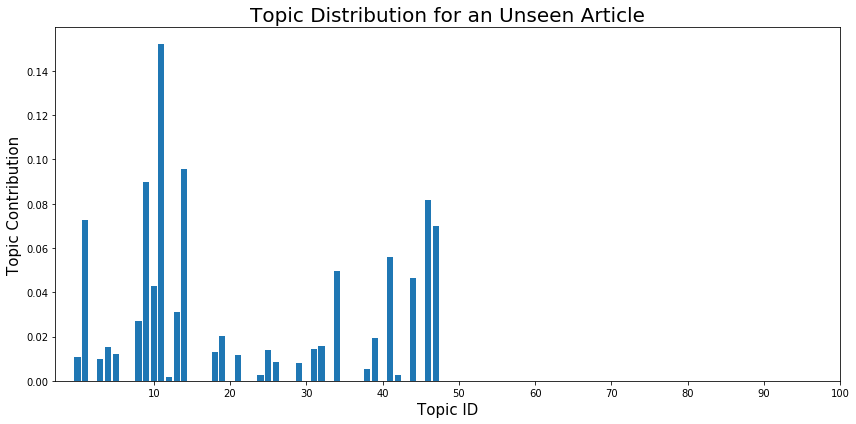

In [33]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [37]:
# print the top 8 contributing topics and their words
for i in new_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

11 [('go', 0.018975839), ('peopl', 0.017050752), ('like', 0.015878962), ('get', 0.015114337), ('know', 0.014301469), ('dont', 0.013838522), ('one', 0.012370292), ('think', 0.012221741), ('thing', 0.011709022), ('want', 0.011508234)] 

14 [('war', 0.038664386), ('world', 0.02413539), ('america', 0.021025945), ('american', 0.015775876), ('us', 0.013717905), ('nation', 0.01143558), ('histori', 0.010251389), ('lie', 0.0075709913), ('murder', 0.006798515), ('militari', 0.0063774628)] 

9 [('human', 0.021825202), ('world', 0.015698472), ('life', 0.012177795), ('us', 0.011673529), ('energi', 0.011177607), ('power', 0.010007967), ('light', 0.009727637), ('new', 0.008290365), ('creat', 0.008036306), ('mind', 0.007862289)] 

46 [('clinton', 0.07100587), ('fbi', 0.039658155), ('hillari', 0.034637854), ('email', 0.033909146), ('investig', 0.027382005), ('comey', 0.013541592), ('foundat', 0.009998847), ('server', 0.008367257), ('depart', 0.007938452), ('inform', 0.007285623)] 

1 [('dr', 0.01051627